In [14]:
%matplotlib notebook
import tifffile
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import mahotas as mh
from colicoords import iter_subplots
import numpy as np
from symfit import Parameter, Variable, Fit, Model, exp
import os

In [4]:
def generate_background(image, median_kernel=11, gaussian_kernel=11, dtype=int):
    assert median_kernel % 2 == 1
    assert image.ndim == 2
    sp_m = medfilt(image, kernel_size=median_kernel)

    #fill corners
    cz = int((median_kernel - 1) / 2)
    sp_m[:cz, :cz] = sp_m[cz, cz]
    sp_m[:cz, -cz:] = sp_m[cz, -cz]
    sp_m[-cz:, -cz:] = sp_m[-cz, -cz]
    sp_m[-cz:, :cz] = sp_m[-cz, cz]

    gf = mh.gaussian_filter(sp_m, gaussian_kernel)

    return gf.astype(dtype)

In [6]:
import symfit
symfit.__version__

'0.5.1'

In [7]:
import colicoords
colicoords.__version__

'0.0.0'

In [5]:
data_dir = r'F:\data\t3ss\20190930_deltaescv_c41_yfp-escv_repeat_1' 
output_dir = r'F:\_processed_big\t3ss\20190930_deltaescv_c41_yfp_repeat_1'

In [23]:
df = tifffile.imread(os.path.join(data_dir, 'darkfield.tif'))
df.shape

(512, 512)

In [24]:
c41_bf = tifffile.imread(os.path.join(data_dir, 'c41', '_BF_140_.tif'))
epec_bf = tifffile.imread(os.path.join(data_dir, 'epec', '_BF_140_.tif'))

In [11]:
c41_bf.shape, epec_bf.shape

((1200, 512, 512), (1200, 512, 512))

<IPython.core.display.Javascript object>


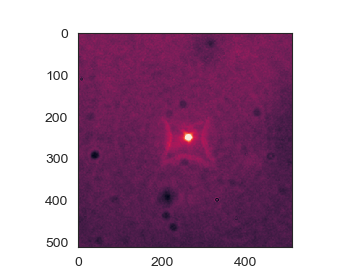

In [13]:
c41_median = np.median(c41_bf, axis=0)
c41_median.shape

plt.figure()
plt.imshow(c41_median)

In [18]:
bf_flat_c41 = (c41_bf - df) / (c41_median - df)

<IPython.core.display.Javascript object>


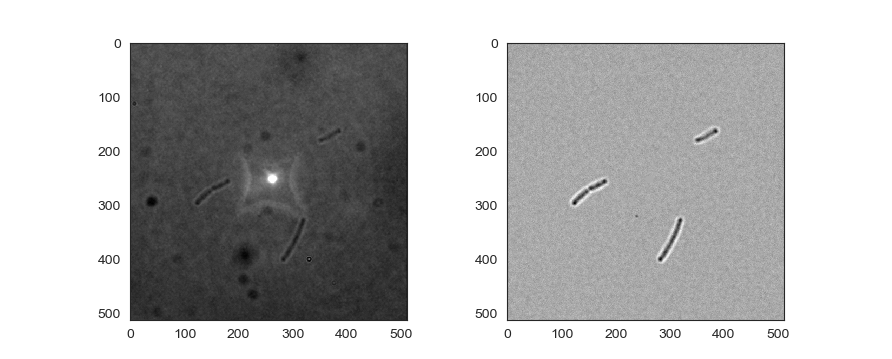

In [19]:
fig, (ax1, ax2) = iter_subplots(1, 2)
ax1.iter_imshow(c41_bf, cmap='gray')
ax2.iter_imshow(bf_flat_c41, cmap='gray')
fig.display()

In [24]:
np.save(os.path.join(output_dir, 'BF_C41_flat.npy'), bf_flat_c41)

In [15]:
bf_flat_c41.shape

(1200, 512, 512)

<IPython.core.display.Javascript object>


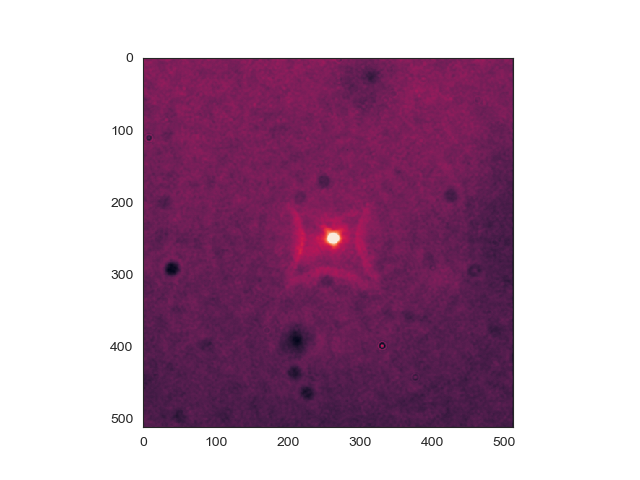

In [25]:
epec_median = np.median(epec_bf, axis=0)
epec_median.shape

plt.figure()
plt.imshow(epec_median)

In [26]:
bf_flat_epec = (epec_bf - df) / (epec_median - df)

<IPython.core.display.Javascript object>


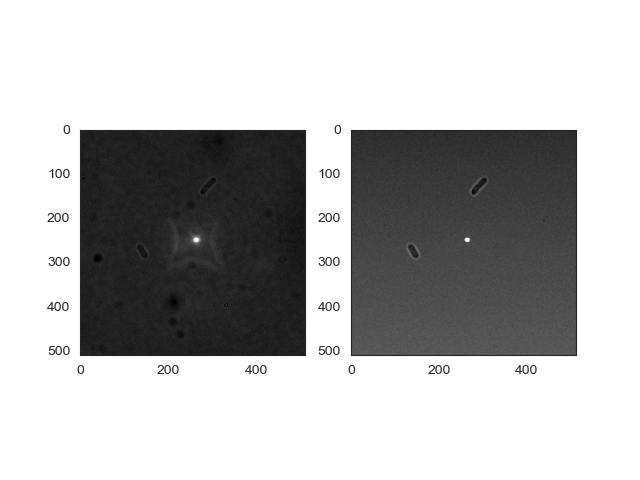

In [30]:
fig, (ax1, ax2) = iter_subplots(1, 2)
ax1.iter_imshow(epec_bf, cmap='gray')
ax2.iter_imshow(bf_flat_epec, cmap='gray')
fig.display()

In [32]:
np.save(os.path.join(output_dir, 'BF_EPEC_flat.npy'), bf_flat_epec)

## Beamprofile

In [7]:
bp = tifffile.imread(os.path.join(data_dir, 'beamprofile', '_514_.tif'))

In [8]:
bp.shape

(12, 512, 512)

<IPython.core.display.Javascript object>


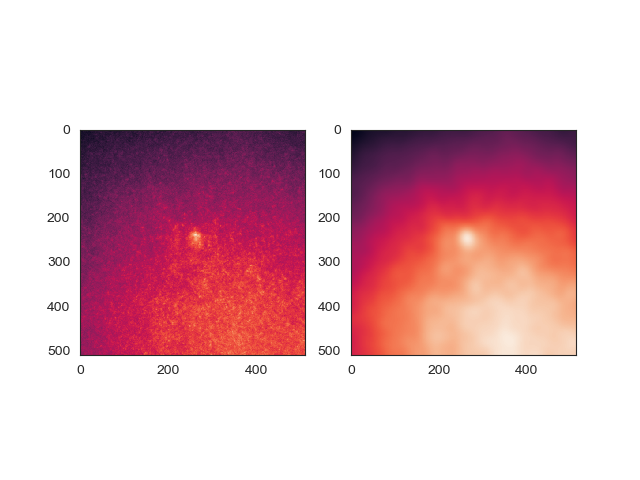

In [10]:
smoothed = generate_background(np.mean(bp, axis=0))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.mean(bp, axis=0))
ax2.imshow(smoothed)

In [15]:
def model_gauss2d(a_val, x_mu_val, y_mu_val, sig_x_val, sig_y_val, base, has_base=True):
    a = Parameter(name='a', value=a_val)
    sig_x = Parameter(name='sig_x', value=sig_x_val)
    sig_y = Parameter(name='sig_y', value=sig_y_val)
    x_mu = Parameter(name='x_mu', value=x_mu_val)
    y_mu = Parameter(name='y_mu', value=y_mu_val)
    if has_base:
        b = Parameter(name='b', value=base)
    else:
        b = base
    x_var = Variable(name='x_var')
    y_var = Variable(name='y_var')
    z_var = Variable(name='z_var')

    model = {z_var: a*exp(-( ((x_var-x_mu)**2/(2*sig_x**2)) + ((y_var-y_mu)**2 / (2*sig_y**2)) )) + b}
    return model

def fit_gauss2d(arr):
    Y, X = np.indices(arr.shape)

    total = arr.sum()
    x = (X*arr).sum()/total
    y = (Y*arr).sum()/total
    col = arr[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = arr[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    base = 1800
    
    
    idx = np.argmax(arr)
    y_mu, x_mu = np.unravel_index(idx, arr.shape)

    print(arr.max(), x_mu, y_mu, width_x, width_y, base)
    model = model_gauss2d(arr.max(), x_mu, y_mu, width_x, width_y, base, has_base=True)

    fit = Fit(model, z_var=arr, x_var=X, y_var=Y)
    return fit.execute(), fit.model

In [16]:
res, model = fit_gauss2d(smoothed)

23023 357 478 308.39238285618063 305.06169409295603 1800


In [17]:
X, Y = np.indices(smoothed.shape)

In [18]:
z = model(x_var=X, y_var=Y, **res.params)[0]

<IPython.core.display.Javascript object>


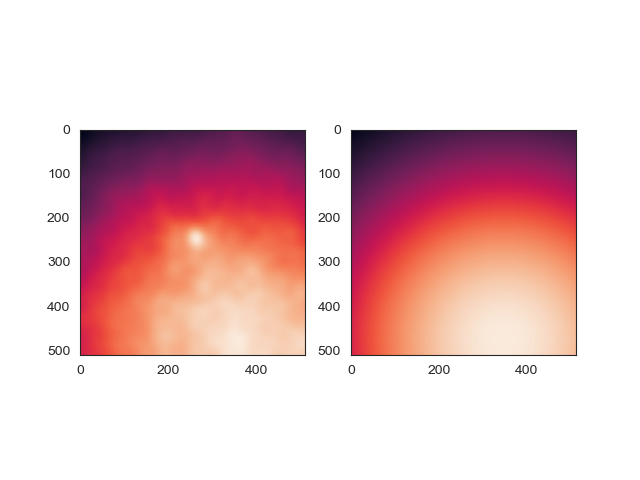

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(smoothed)
ax2.imshow(z.T)

<IPython.core.display.Javascript object>


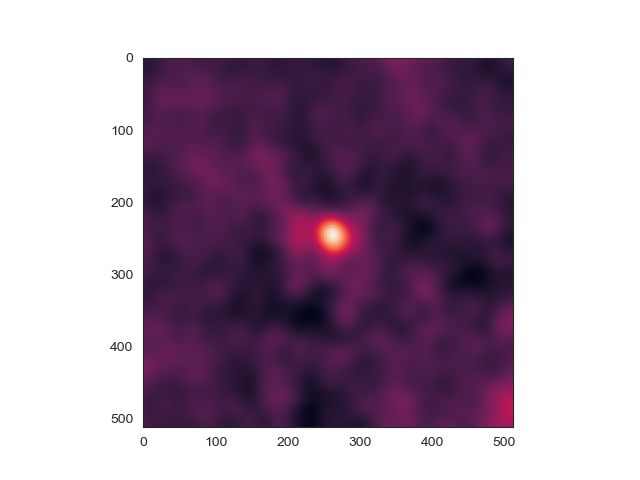

In [21]:
plt.figure()
plt.imshow(smoothed - z.T)

In [25]:
bp_final = z.T - df
bp_final /= bp_final.max()
bp_final.max()

1.0

<IPython.core.display.Javascript object>


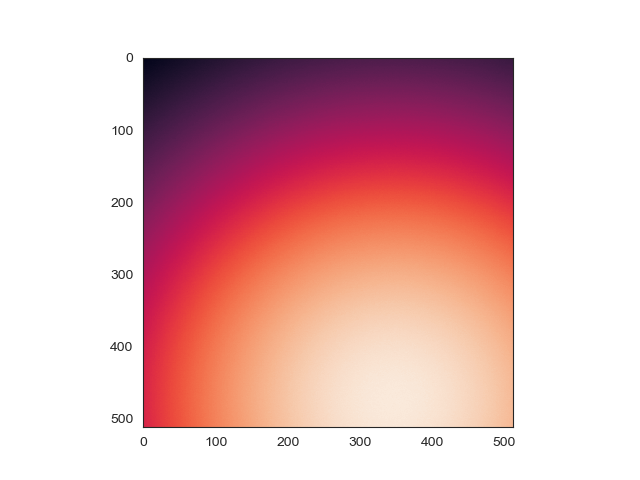

In [26]:
plt.figure()
plt.imshow(bp_final)

In [27]:
tifffile.imsave(os.path.join(output_dir, 'beamprofile.tif'), bp_final)

In [28]:
np.save(os.path.join(output_dir, 'beamprofile.npy'), bp_final)

In [44]:
cells = ['c41', 'epec']
files = ['514_g100', '514_g500']

for c in cells:
    for f in files:
        arr = tifffile.imread(os.path.join(data_dir, c, f + '.tif')).astype(float)
        new_arr = arr.reshape(-1, *arr.shape[2:])
        new_arr /= bp_final
        np.save(os.path.join(output_dir, '{}_{}.npy'.format(c, f)), new_arr)

In [42]:
arr.shape[2:]

(512, 512)

<IPython.core.display.Javascript object>


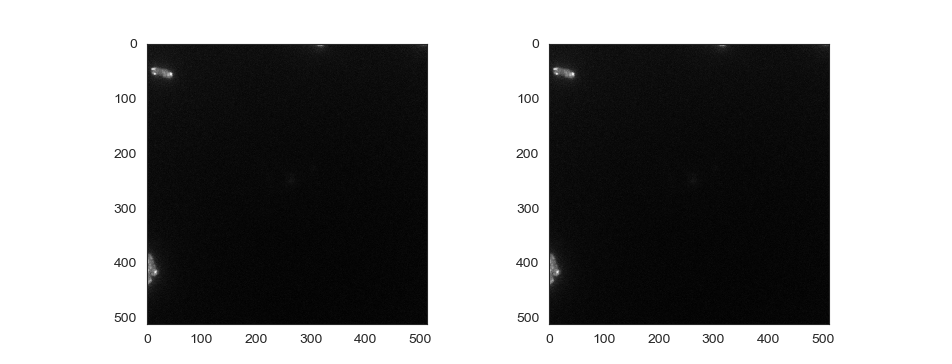

In [46]:
fig, (ax1, ax2) = iter_subplots(1, 2)
ax1.iter_imshow(arr.reshape(-1, *arr.shape[2:]), cmap='gray')
ax2.iter_imshow(new_arr, cmap='gray')
fig.display()

In [33]:
arr.max()

57741

In [34]:
arr +=1

In [35]:
arr

array([[[[2050, 2041, 2022, ..., 2058, 2101, 2001],
         [2024, 2016, 2014, ..., 1985, 2024, 2059],
         [2049, 2068, 1982, ..., 2077, 2067, 2012],
         ...,
         [2054, 2020, 2137, ..., 2175, 2032, 2055],
         [2043, 1992, 2018, ..., 2151, 2051, 2111],
         [1973, 2103, 2075, ..., 2083, 2112, 2037]],

        [[1937, 2008, 2095, ..., 2084, 2042, 2169],
         [2001, 1996, 2278, ..., 2204, 2180, 2092],
         [2105, 2096, 2102, ..., 2075, 2148, 2291],
         ...,
         [2019, 1974, 2224, ..., 2268, 2245, 2086],
         [2034, 2193, 2155, ..., 2130, 2213, 2014],
         [2034, 2044, 1972, ..., 2115, 2113, 2239]],

        [[2069, 2055, 2039, ..., 2188, 2174, 2223],
         [2041, 2154, 2228, ..., 2165, 2200, 2164],
         [2154, 2090, 2143, ..., 2207, 2140, 2055],
         ...,
         [2172, 2247, 2083, ..., 2283, 2263, 2221],
         [2053, 1985, 2101, ..., 2116, 2228, 2326],
         [2255, 2201, 2180, ..., 2226, 2368, 2350]],

        ...,

  